# CAB420, Clustering, Example 4: Clustering Applications
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

In this example we'll look at two example clustering applications:
* Segmentation / Knowledge Discovery
* Anomaly Detection

In this example we're using some data from the New York Citibike service (more data can be found [here](https://www.citibikenyc.com/system-data)). We'll use data from three months:
* July, 2019
* December, 2019
* July, 2020

Note that with clustering, we don't always have the same training, validation and testing splits that we do for supervised models. This is due to the fact that we don't have labels, and so evaluating overfitting is much more challenging (if at all possible).

### Segmentation / Knowledge Discovery

This is a common task when we have a large dataset with no labels. Often in such situations we seek to understand what is present in the data by grouping related items. This also aids visualisation, and can also help simplify the data by reducing a large dataset to a few representitive examples (i.e. cluster centres).

In this task, we'll use the first two sets (July and December '19) to train our clustering models. We'll then use these models to see if there is a difference in bike usage between July '19, Decmeber '19 and July '20. 

### Anomaly Detection

This task involves finding points that are unusual, or abnormal. A typical process for this is:
* Train the model on a batch of normal data
* For a new point, determine if it's fit the trained model. If it doesn't, then the point is abnormal

Again we'll use the first two sets (July and December '19) to train our clustering models. We'll then look for abnormalities in the July '20 data. Note that this therefore assumes that the July and December '19 data does not contain any abnormal points, which is probably not the case, though at least we can reasonably expect them to be very scarce.

### Runtime Warning

Finally, a quick warning that due to the size of these datasets the two blocks of code that compute reconsturction errors, approximate BIC and BIC for different value of $K$ are very slow. The rest of code runs quite quickly.

## Too Long; Didn't Read
* Data standardisation can greatly change the results that we see from a clustering algorithm.
* We can use clustering to help find patterns in a dataset. Each cluster can be seen as a behaviour or particular pattern of use, and by analysing the frequency of different clusters we can see how similar to sets of data (i.e two different time periods) are.
 * K-Means and GMMs can both work for this, however with K-Means we are limited to spherical clusters which may or may not be appropriate.
 * We can compare data sets visually, but can also use similarlity measures such as histogram intersection or the Bhattacharyya coefficient
 * Increasing the number of clusters will highlight differences between datasets by breaking clusters down into finer-grained sets. However, overclustering will simply add noise (though determining when you have reached the point of overclustering is tricky).
* Clustering can also be used to perform anomaly detection, by finding points that are a poor fit to the trained model. Ideally, this involves training on normal data only, such that the abnormal points will fit any model badly. In practice, this is often hard to achieve.
 * K-Means can be used for abormality detection by using the distance between a point and it's assigned cluster centre; however for points that lie at the boundary between two clusters this can incorrectly report these points as an anomaly, when in fact they are just points that are hard to assign.
 * GMMs are a more natural fit for anomaly detection as we can obtain a likelihood indicating how likely it is that a point was produced by the modelled distribution. This can allow us to find the points that are least likely, and these become our abnormalities.

In [23]:
import pandas
import numpy
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from matplotlib import cm
from datetime import datetime

## Data Setup

We'll load up our three datassets. You are encouraged to grab other example data from [here](https://www.citibikenyc.com/system-data) and further explore the data and these methods.

In [24]:
data_jul_19 = pandas.read_csv('../data/citibike/JC-201907-citibike-tripdata.csv')
data_dec_19 = pandas.read_csv('../data/citibike/JC-201912-citibike-tripdata.csv')
data_jul_20 = pandas.read_csv('../data/citibike/JC-202007-citibike-tripdata.csv')

Our data has a lot of columns that we don't care about for these purposes. While we can use any of these dimensions in our clustering if we so choose (though the text columns would make things more challenging), we'll use the following:
* tripduration
* start station latitude
* start station longitude
* end station latitude
* end station longitude

As well as dropping those columns, we'll do some other data clearing. In particular we will:
* Remove rows with a missing value, done via dropna
* Optionally filter based on the trip duration, to remove very long (and likely erroneous) trips. As we will see below, we have a small number of huge trips that look more like someone abandoned the bike and never actually formally completed their trip
* Optionally filter based on lat/lon range, to make sure that the same set of stations are in all datasets

In [25]:
def clean_data(data, time_limit = None, lat_range = None, lon_range = None):
    data_cleaned = data.dropna()
    if (time_limit is not None):
        data_cleaned = data_cleaned[data_cleaned.tripduration < time_limit]
        
    if (lon_range is not None):
        data_cleaned = data_cleaned[(data_cleaned['start station longitude'] >= lon_range[0]) & \
                                    (data_cleaned['start station longitude'] <= lon_range[1]) & \
                                    (data_cleaned['end station longitude'] >= lon_range[0]) & \
                                    (data_cleaned['end station longitude'] <= lon_range[1])]

    if (lat_range is not None):
        data_cleaned = data_cleaned[(data_cleaned['start station latitude'] >= lat_range[0]) & \
                                    (data_cleaned['start station latitude'] <= lat_range[1]) & \
                                    (data_cleaned['end station latitude'] >= lat_range[0]) & \
                                    (data_cleaned['end station latitude'] <= lat_range[1])]
    
    data_cleaned.reset_index(inplace=True)
    return data_cleaned

time_limit = 7200
min_lon = -74.09
max_lon = -74.01
min_lat = 40.71
max_lat = 40.75

data_jul_19 = data_jul_19.drop(['stoptime', 'start station id', 'start station name', 'end station id', 'end station name', 'bikeid', 'usertype', 'birth year', 'gender'], axis=1)
data_jul_19 = clean_data(data_jul_19, time_limit, [min_lat, max_lat], [min_lon, max_lon])
data_dec_19 = data_dec_19.drop(['stoptime', 'start station id', 'start station name', 'end station id', 'end station name', 'bikeid', 'usertype', 'birth year', 'gender'], axis=1)
data_dec_19 = clean_data(data_dec_19, time_limit, [min_lat, max_lat], [min_lon, max_lon])
data_jul_20 = data_jul_20.drop(['stoptime', 'start station id', 'start station name', 'end station id', 'end station name', 'bikeid', 'usertype', 'birth year', 'gender'], axis=1)
data_jul_20 = clean_data(data_jul_20, time_limit, [min_lat, max_lat], [min_lon, max_lon])

We can now store the number of samples in each dataset, and combine our two lots of 2019 data to form our training set.

In [26]:
samples_jul_19 = len(data_jul_19.index)
samples_dec_19 = len(data_dec_19.index)
samples_jul_20 = len(data_jul_20.index)
combined_data = pandas.concat([data_jul_19, data_dec_19], axis = 0)
combined_data.reset_index(inplace=True)

Finally, we can pull our the data that we're going to use for clustering, which now simply involves converting our pandas tables to a numpy array. There is really no need to do this and you can leave the data in a pandas array, I (SD) just perfer to work with it in a numpy array once I've got all the pre-processing sorted out.

In [27]:
data_to_cluster = combined_data[['tripduration', 'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude']].to_numpy()
data_to_cluster_jul20 = data_jul_20[['tripduration', 'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude']].to_numpy()

We'll now have a quick visualisation of the data. First the start and end locations. This looks fairly standard, and we have consistent spots across all the data.

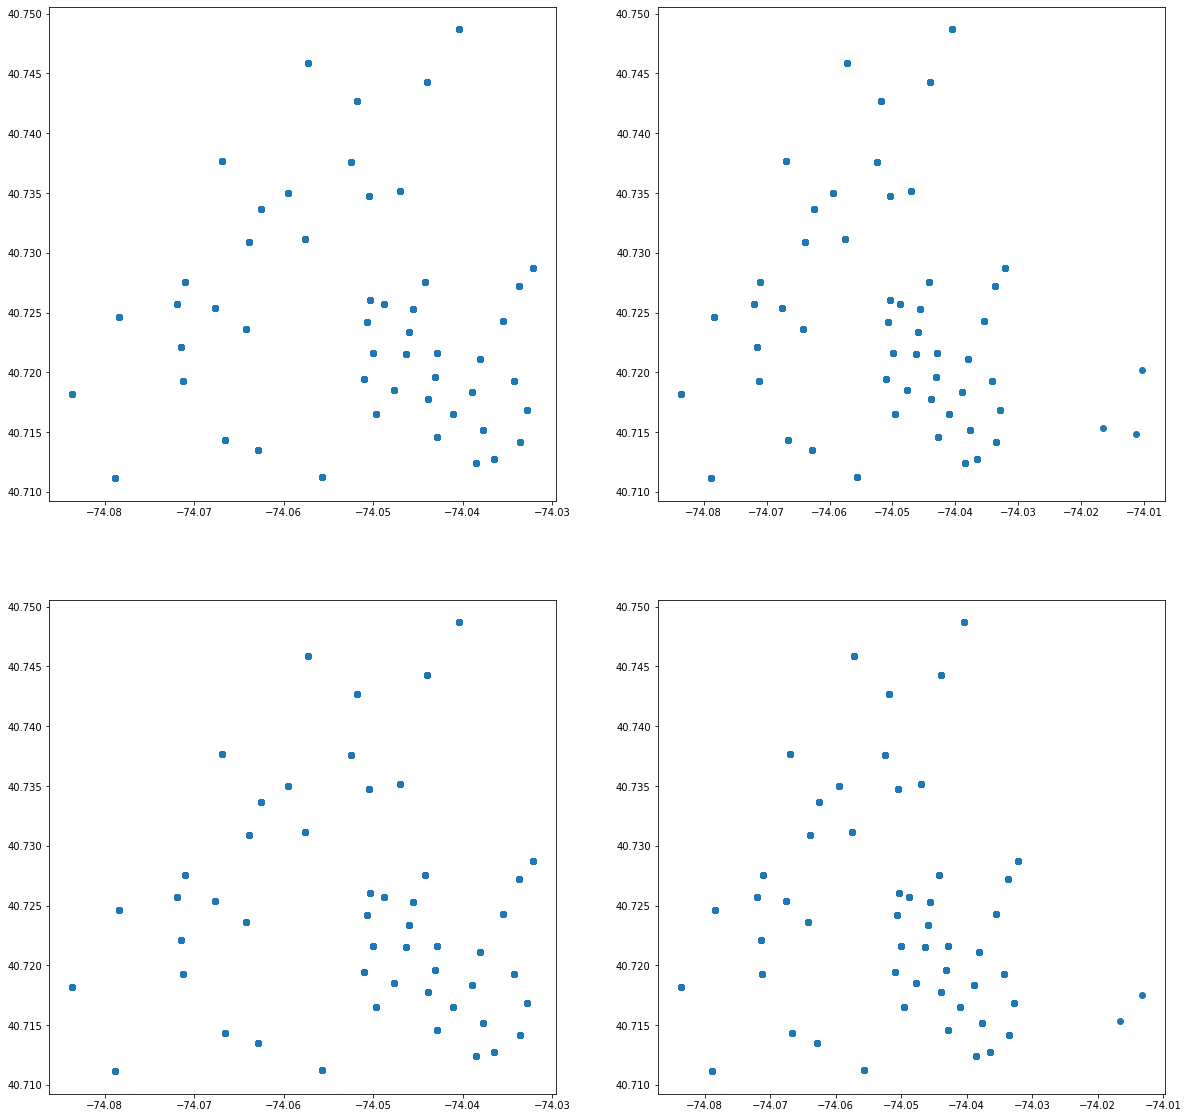

In [32]:
fig = plt.figure(figsize=[20, 20])
ax = fig.add_subplot(2, 2, 1)
ax.scatter(combined_data['start station longitude'], combined_data['start station latitude'])
ax = fig.add_subplot(2, 2, 2)
ax.scatter(combined_data['end station longitude'], combined_data['end station latitude'])
ax = fig.add_subplot(2, 2, 3)
ax.scatter(data_jul_20['start station longitude'], data_jul_20['start station latitude'])
ax = fig.add_subplot(2, 2, 4)
ax.scatter(data_jul_20['end station longitude'], data_jul_20['end station latitude'])

Next up, we'll have a look at a box plot and here we see a potential issue. Our data series are in very different ranges, with the first dimension (tripduration) dominating. If left unchecked, this will lead to the trip duration dominating our clustering.

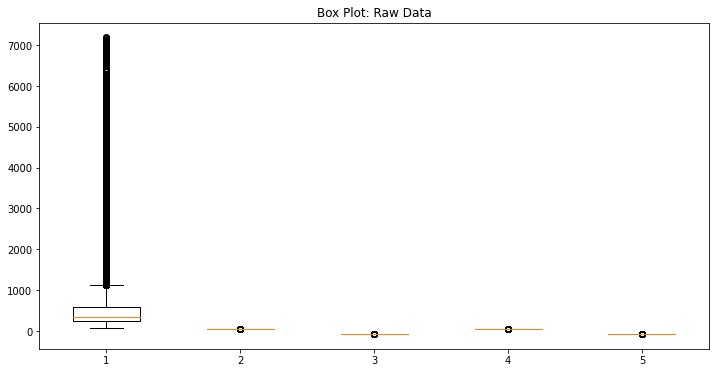

In [33]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(data_to_cluster)
ax.set_title('Box Plot: Raw Data');

As such, we'll standardise the data.

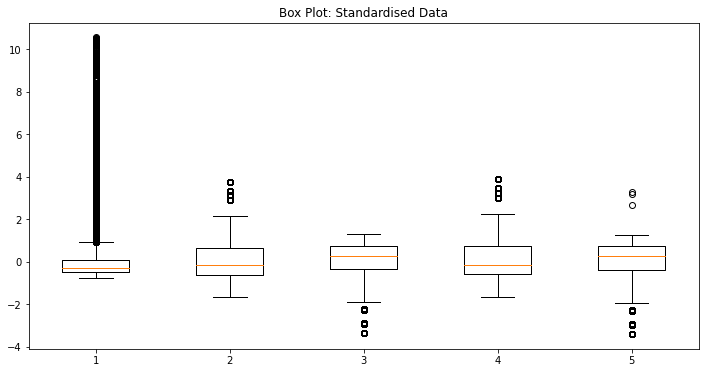

In [34]:
data_to_cluster_mu = numpy.mean(data_to_cluster, axis=0)
data_to_cluster_sigma = numpy.std(data_to_cluster, axis=0)
data_to_cluster_std = (data_to_cluster - data_to_cluster_mu)/data_to_cluster_sigma
data_to_cluster_jul20_std = (data_to_cluster_jul20 - data_to_cluster_mu)/data_to_cluster_sigma
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(data_to_cluster_std)
ax.set_title('Box Plot: Standardised Data');

## Application 1: Segmentation / Knowledge Discovery

We can now move onto our first application: Segmentation / Knowledge Discovery.

Before we can proceed, we need to come up with an estimate of K. We'll do that for K-means first.

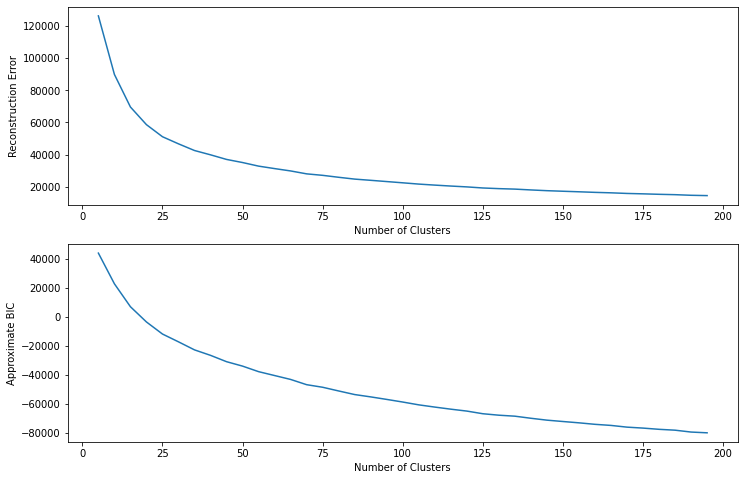

In [35]:
def compute_approximate_bic(kmeans, X):
    
    k = numpy.shape(kmeans.cluster_centers_)[0]*(numpy.shape(kmeans.cluster_centers_)[1] + 1)
    m = len(X)
    
    approx_bic = m*numpy.log(kmeans.inertia_ / m) + k*numpy.log(m)
    return approx_bic    

recon_error = []
bic = []
for i in range (5, 200, 5):
    kmeans = KMeans(n_clusters=(i+1), random_state=4).fit(data_to_cluster_std)
    bic.append(compute_approximate_bic(kmeans, data_to_cluster_std))
    recon_error.append(kmeans.inertia_)

fig = plt.figure(figsize=[12, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(range (5, 200, 5), recon_error)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Reconstruction Error');    
ax = fig.add_subplot(2, 1, 2)
ax.plot(range (5, 200, 5), bic)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Approximate BIC');    

From the above, the "elbow" method gives us a K of around 10-15, while the approximate BIC is yet to reach a minimum. 

Looking at the BIC for a GMM we get the following.

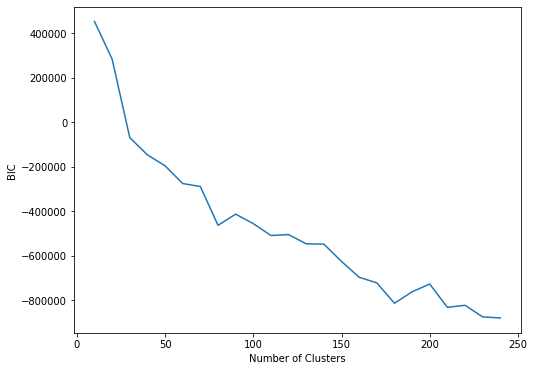

In [36]:
bics = []
for i in range (10, 250, 10):
    gmm = GaussianMixture(i+1, random_state=4)
    gmm.fit(data_to_cluster_std)
    bics.append(gmm.bic(data_to_cluster_std))
    
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(10, 250, 10), bics)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('BIC');

We are seemingly reaching a minimum at about 250 - the plots looks to have flattened out, however this could be noise too and we may not have quite bottomed out - but at least we are close.

Considering our task, which is to group the data into related trips and analyse the cluster distributions, larger numbers of clusters will mean more fine-grained segmentation and more data to analyse. This is not necessarily a bad thing (particularly for a whole city where a large number of behaviours are possible), however for our task the ~250 cluster option is probably overkill. As such, we'll run with 20.

While methods such as these are helpful for selecting K, there is always scope to select a different value based on your own needs. In our case, the difficulties in visualising and analysing ~250 distinct clusters in a shortish python script make this value a little impractical. As such, we'll pick 10 which is (roughly) the elbow of the approximate BIC curve. We'll use this value for both K-means and our GMM.

### K-Means

We'll start with K-Means. Note we've defined $K$ below. If you wish to re-run this with a different value of $K$, you can simply change this value.

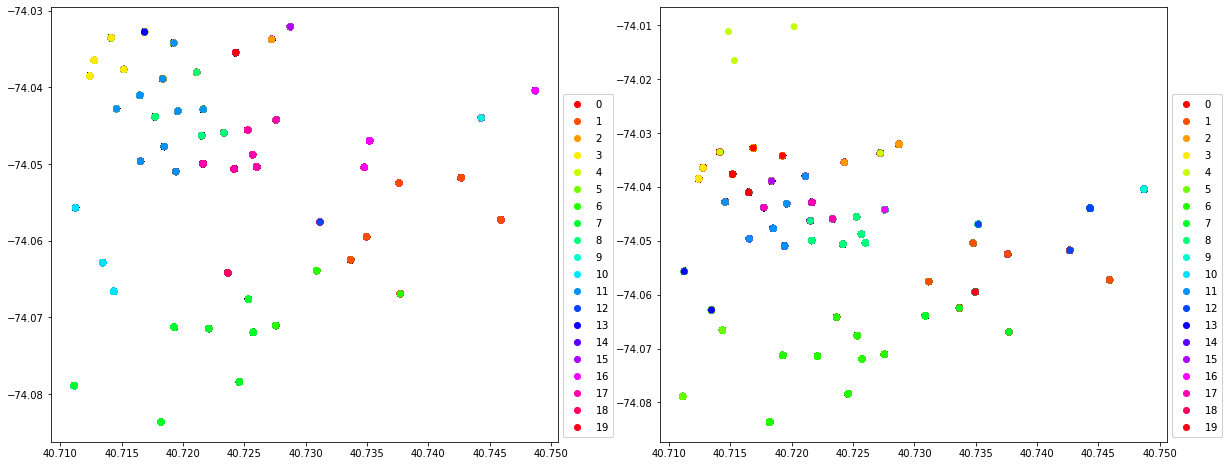

In [122]:
k = 20

kmeans = KMeans(n_clusters=k, random_state=4).fit(data_to_cluster_std)
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 2, 1)
scatter = ax.scatter(data_to_cluster[:,1], data_to_cluster[:,2], c=kmeans.labels_, cmap=cm.get_cmap('hsv'));
legend1 = ax.legend(*scatter.legend_elements(num=k), loc="lower left", bbox_to_anchor=(1, 0))
ax.add_artist(legend1)

ax = fig.add_subplot(1, 2, 2)
scatter = ax.scatter(data_to_cluster[:,3], data_to_cluster[:,4], c=kmeans.labels_, cmap=cm.get_cmap('hsv'));
legend1 = ax.legend(*scatter.legend_elements(num=k), loc="lower left", bbox_to_anchor=(1, 0))
ax.add_artist(legend1)

We can see our clusters are broadly capturing different patterns of movement, between groups of bike stations. Inspecting the cluster centres, we see that a couple of the clusters seem to correspond to long duration trips.

From this, we could also assign semantic labels/descriptions to each of these clusters. This is beyond the scope of this example (and my knowledge of New York geography).

In [123]:
scaled_centres = kmeans.cluster_centers_*data_to_cluster_sigma + data_to_cluster_mu
for i in range(k):
    print('Cluster Centre %d: %1.2f, %1.3f, %1.3f, %1.3f, %1.3f' % (i, scaled_centres[i, 0], scaled_centres[i, 1], scaled_centres[i, 2], scaled_centres[i, 3], scaled_centres[i, 4]))

Cluster Centre 0: 502.43, 40.722, -74.044, 40.716, -74.036
Cluster Centre 1: 447.15, 40.736, -74.058, 40.737, -74.058
Cluster Centre 2: 415.10, 40.720, -74.039, 40.727, -74.034
Cluster Centre 3: 292.96, 40.716, -74.036, 40.716, -74.037
Cluster Centre 4: 1724.27, 40.721, -74.039, 40.722, -74.039
Cluster Centre 5: 752.35, 40.718, -74.043, 40.712, -74.060
Cluster Centre 6: 521.70, 40.730, -74.065, 40.723, -74.072
Cluster Centre 7: 428.56, 40.723, -74.071, 40.731, -74.064
Cluster Centre 8: 331.41, 40.720, -74.043, 40.726, -74.047
Cluster Centre 9: 733.63, 40.745, -74.046, 40.743, -74.047
Cluster Centre 10: 658.82, 40.712, -74.061, 40.718, -74.042
Cluster Centre 11: 288.16, 40.718, -74.043, 40.719, -74.044
Cluster Centre 12: 1341.79, 40.723, -74.043, 40.743, -74.047
Cluster Centre 13: 5179.16, 40.720, -74.046, 40.720, -74.046
Cluster Centre 14: 2708.09, 40.718, -74.049, 40.717, -74.050
Cluster Centre 15: 435.85, 40.727, -74.033, 40.722, -74.039
Cluster Centre 16: 880.68, 40.741, -74.049, 40

We can think of each cluster being a type of behaviour. As such, we can look at how often each cluster (behaviour) occurs as a way to capture overall usage patterns and look for changes in usage over time.

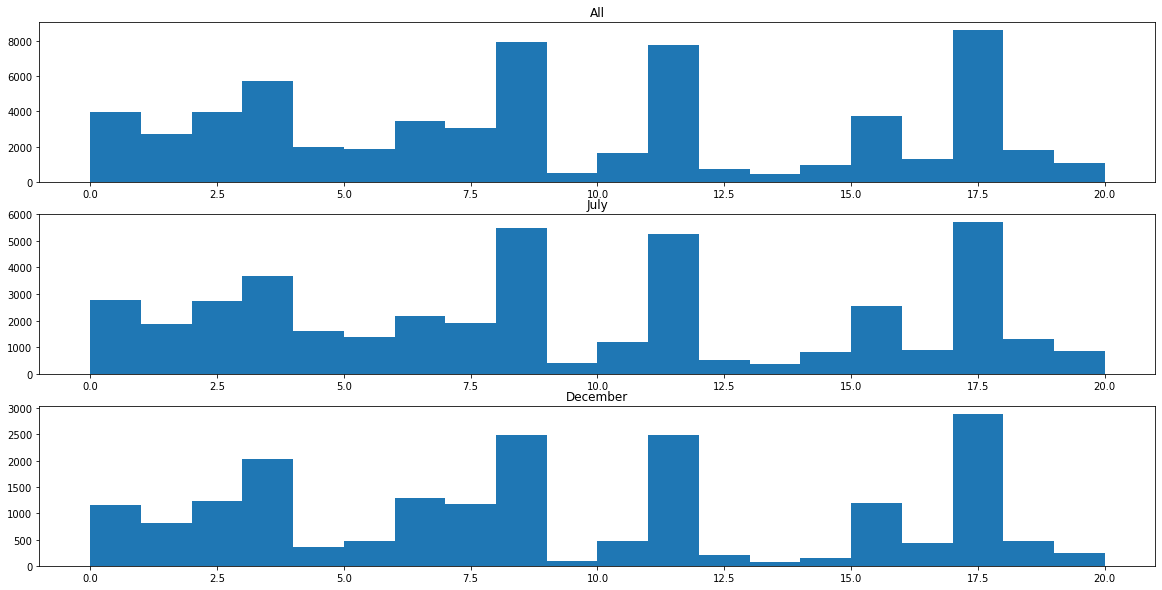

In [124]:
def draw_bars(labels, jul, dec, k):

    bins = list(range(k + 1))
    
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(3, 1, 1)
    ax.hist(labels, bins=bins)
    ax.set_title('All')
    ax = fig.add_subplot(3, 1, 2)
    ax.hist(jul, bins=bins)
    ax.set_title('July')
    ax = fig.add_subplot(3, 1, 3)
    ax.hist(dec, bins=bins)
    ax.set_title('December')
    
draw_bars(kmeans.labels_, kmeans.labels_[0:samples_jul_19], kmeans.labels_[samples_jul_19:], k)

Considering the usage for July and December 2019, we see little variation. All plots look fairly similar, suggesting that there is no major change in usage.

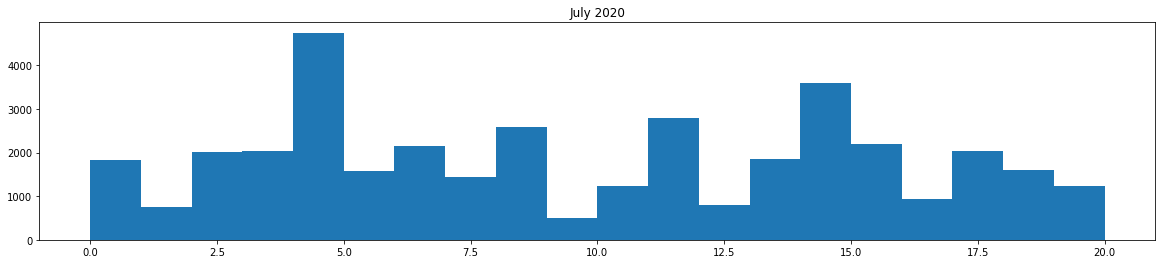

In [125]:
labels = kmeans.predict(data_to_cluster_jul20_std)
bins = list(range(k + 1))
fig = plt.figure(figsize=[20, 4])
ax = fig.add_subplot(1, 1, 1)
ax.hist(labels, bins=bins)
ax.set_title('July 2020');

Comparing July 2020 to the above plots, we see quite a departure. Trends clearly seem to have changed, and at this point, if we wished to, we could now analyse individual clusters to understand what behaviours have changed. 

While there is a clear change, a limitation of the above analysis is that it's quite subjective. It's based on manually inspecting these plots and so there is lots of scope for different people to interpret the data differently. To overcome this, we need a way to compare two histograms. There are a lot of possible approaches for this, but we'll use a fairly straight forward method which is the histogram intersection. To compute the histogram intersection we need to:
* Normalise the histograms, i.e. divide each bin of the histogram by the the sum of the histogram, such that the histogram sums to one
* To compare two histograms, sum the minimal value across each bin

For two histograms that are identical, the intersection will be 1. For two that are totally different, the intersection will be 0.

In [126]:
bin_counts_all, _ = numpy.histogram(kmeans.labels_, bins)
bin_counts_jul19, _ = numpy.histogram(kmeans.labels_[0:samples_jul_19], bins)
bin_counts_dec19, _ = numpy.histogram(kmeans.labels_[samples_jul_19:], bins)
bin_counts_jul20, _ = numpy.histogram(labels, bins)

def normalise_histogram(hist):
    return hist / numpy.sum(hist)

bin_counts_all = normalise_histogram(bin_counts_all)
bin_counts_jul19 = normalise_histogram(bin_counts_jul19)
bin_counts_dec19 = normalise_histogram(bin_counts_dec19)
bin_counts_jul20 = normalise_histogram(bin_counts_jul20)

def histogram_intersection(hist1, hist2):
    total = 0
    for i, j in zip(hist1, hist2):
        total += min(i, j)
    return total

print('All vs July\'19: %f' % (histogram_intersection(bin_counts_all, bin_counts_jul19)))
print('All vs Dec\'19:  %f' % (histogram_intersection(bin_counts_all, bin_counts_dec19)))
print('All vs July\'20: %f' % (histogram_intersection(bin_counts_all, bin_counts_jul20)))

All vs July'19: 0.976521
All vs Dec'19:  0.948124
All vs July'20: 0.716736


Computing the histogram intersections, we can see that we have 2019 looking very similar; with July'20 recording a substantial change. This backs up what we could see from the plots, which is good.

While this (and other metrics) are good, there is no clear value as to at what point things become "too different". This is something that depends on the application and what is being investigated.

### GMM

We'll now move onto the GMM.

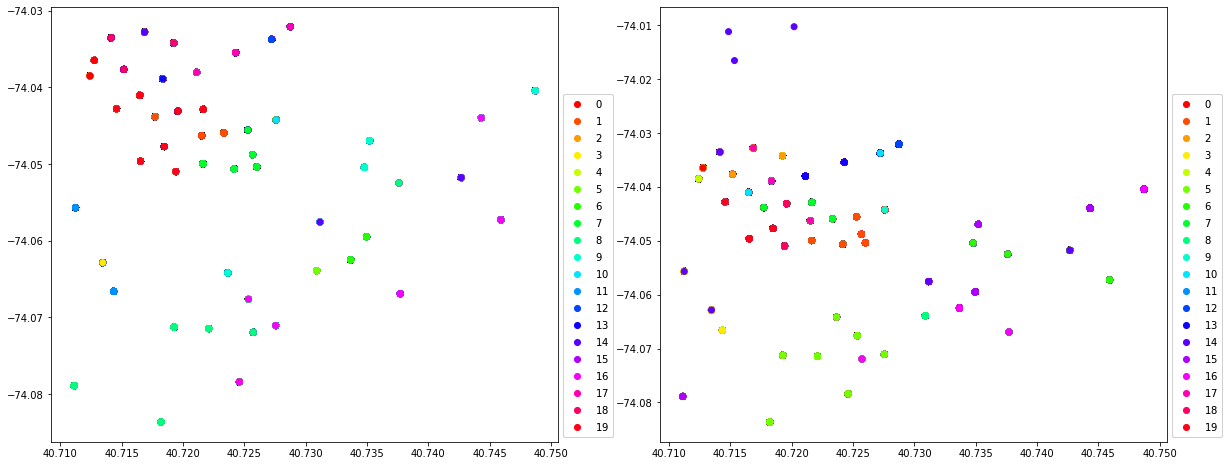

In [127]:
gmm = GaussianMixture(k, random_state=4)
gmm.fit(data_to_cluster_std)
labels = gmm.predict(data_to_cluster_std)
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 2, 1)
scatter = ax.scatter(data_to_cluster[:,1], data_to_cluster[:,2], c=labels, cmap=cm.get_cmap('hsv'));
legend1 = ax.legend(*scatter.legend_elements(num=k), loc="lower left", bbox_to_anchor=(1, 0))
ax.add_artist(legend1)

ax = fig.add_subplot(1, 2, 2)
scatter = ax.scatter(data_to_cluster[:,3], data_to_cluster[:,4], c=labels, cmap=cm.get_cmap('hsv'));
legend1 = ax.legend(*scatter.legend_elements(num=k), loc="lower left", bbox_to_anchor=(1, 0))
ax.add_artist(legend1)

Looking at the above, we can see that we have far more complex cluster boundaries than we had with the GMM. This is expected, as K-means will create spherical clusters, while with a GMM we can capture clusters of varying shapes and densities. In this case, we could argue that we are getting a much better representation of the data.

In [128]:
scaled_centres = gmm.means_*data_to_cluster_sigma + data_to_cluster_mu
for i in range(k):
    print('Cluster Centre %d: %1.2f, %1.3f, %1.3f, %1.3f, %1.3f' % (i, scaled_centres[i, 0], scaled_centres[i, 1], scaled_centres[i, 2], scaled_centres[i, 3], scaled_centres[i, 4]))

Cluster Centre 0: 1755.21, 40.721, -74.046, 40.721, -74.046
Cluster Centre 1: 237.87, 40.720, -74.044, 40.725, -74.047
Cluster Centre 2: 394.58, 40.720, -74.044, 40.716, -74.035
Cluster Centre 3: 678.35, 40.718, -74.044, 40.712, -74.059
Cluster Centre 4: 212.13, 40.715, -74.035, 40.716, -74.035
Cluster Centre 5: 385.06, 40.730, -74.064, 40.723, -74.072
Cluster Centre 6: 438.64, 40.733, -74.062, 40.740, -74.055
Cluster Centre 7: 247.32, 40.725, -74.048, 40.720, -74.043
Cluster Centre 8: 402.34, 40.725, -74.069, 40.731, -74.064
Cluster Centre 9: 868.97, 40.734, -74.058, 40.722, -74.041
Cluster Centre 10: 721.31, 40.721, -74.043, 40.721, -74.043
Cluster Centre 11: 598.04, 40.715, -74.061, 40.718, -74.042
Cluster Centre 12: 167.03, 40.728, -74.034, 40.728, -74.035
Cluster Centre 13: 385.19, 40.720, -74.040, 40.726, -74.035
Cluster Centre 14: 2110.77, 40.724, -74.051, 40.724, -74.050
Cluster Centre 15: 1001.89, 40.721, -74.041, 40.733, -74.060
Cluster Centre 16: 398.51, 40.736, -74.057, 40.

Analysing our histograms, we are seeing similar trends in 2019, i.e. behaviours don't change much between July and December.

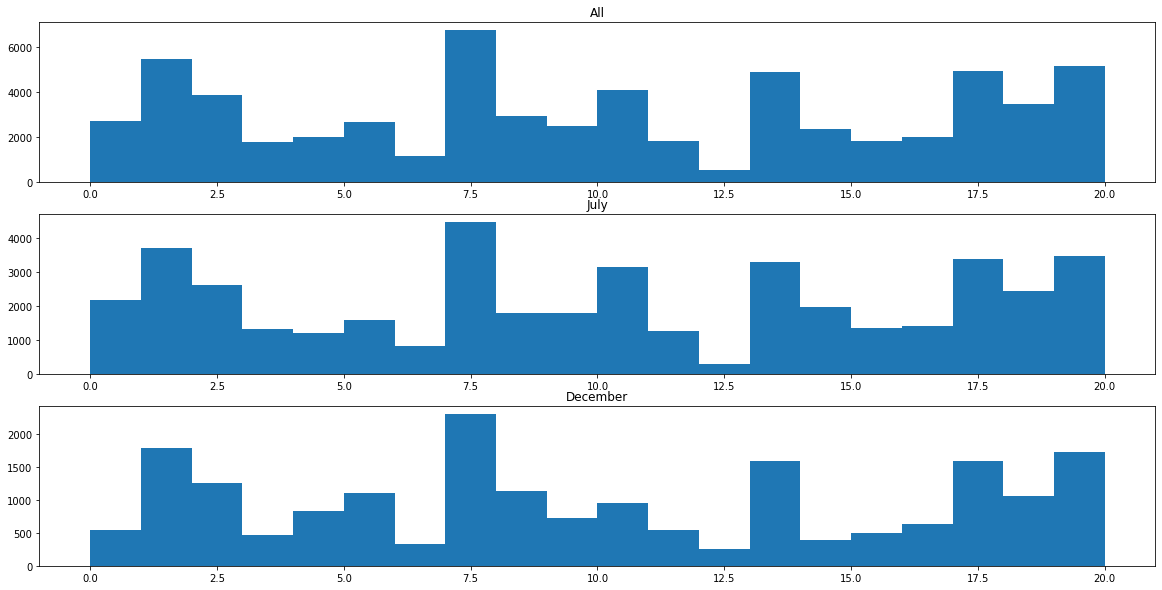

In [129]:
draw_bars(labels, labels[0:samples_jul_19], labels[samples_jul_19:], k)

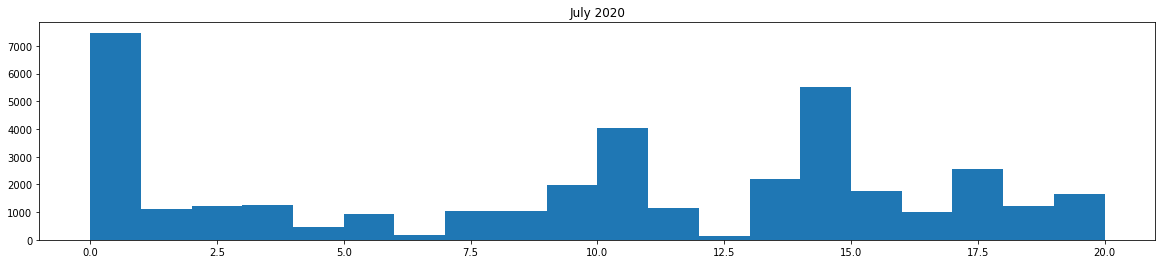

In [130]:
labels_jul20 = gmm.predict(data_to_cluster_jul20_std)
bins = list(range(k + 1))
fig = plt.figure(figsize=[20, 4])
ax = fig.add_subplot(1, 1, 1)
ax.hist(labels_jul20, bins=bins)
ax.set_title('July 2020');

We do however see a much larger change between our 2019 data and the July 2020 sample, perhaps an even more dramatic change than we saw with k-means.

In [131]:
bin_counts_all, _ = numpy.histogram(labels, bins)
bin_counts_jul19, _ = numpy.histogram(labels[0:samples_jul_19], bins)
bin_counts_dec19, _ = numpy.histogram(labels[samples_jul_19:], bins)
bin_counts_jul20, _ = numpy.histogram(labels_jul20, bins)

bin_counts_all = normalise_histogram(bin_counts_all)
bin_counts_jul19 = normalise_histogram(bin_counts_jul19)
bin_counts_dec19 = normalise_histogram(bin_counts_dec19)
bin_counts_jul20 = normalise_histogram(bin_counts_jul20)

print('All vs July\'19: %f' % (histogram_intersection(bin_counts_all, bin_counts_jul19)))
print('All vs Dec\'19:  %f' % (histogram_intersection(bin_counts_all, bin_counts_dec19)))
print('All vs July\'20: %f' % (histogram_intersection(bin_counts_all, bin_counts_jul20)))

All vs July'19: 0.970182
All vs Dec'19:  0.934121
All vs July'20: 0.660650


That visual change is reflected in the histogram intersection, where we see a drop in similarity between July'20 and the other data; though oddly we saw a larger (albeit similar) drop when looking at k-means.

### Further Thoughts

With this application, we'd see different results if:
* we re-run with a different number of clusters
* we change the random seed

Changing the random seed should lead to minor variations - for the most part we'd expect this will lead to clusters being "swapped" (i.e. clusters 1 and 2 being swapped, but being close to the same), with just small changes around boundary points.

Increasing the number of clusters will allow the analysis of more fine-grained behaviours, and will help to identify fine-grained differences in the data. However as we add more and more clusters, it becomes harder to assign semantic meaning to them all, and we may find that we end up over-clustering the data (i.e. having two or more clusters that capture the same underlying behaviour).

## Application 2: Anomaly Detection

Let's move onto our second application, anomaly detection.

The standard setup for anomly detection is to train on normal data, and then look at how well a point fits the model learned on normal data. To do this, we need to define a threshold for what constitues an abnormal point. Usually, to do this we'd have:
* A training set with normal data only to learn the model
* A validation set with some known abnormal points to learn the optimal threshold
* A testing set, to test the model

We'll take a slightly different approach we have no labels for any points. We'll decide that 0.05% of points should be abnormal, and find the most unusual 0.05% of points.

In [132]:
abnormal_amount = 0.0005;
abnormal_count = int(len(data_to_cluster_jul20_std)*(1.0 - abnormal_amount))
abnormal_samples = len(data_to_cluster_jul20_std) - abnormal_count
print(abnormal_samples)

19


For our data, this means that we're looking at the weirdest 19 bike trips.

### K-Means

Let's start with K-means. We'll use the same model we had above with 20 clusters.

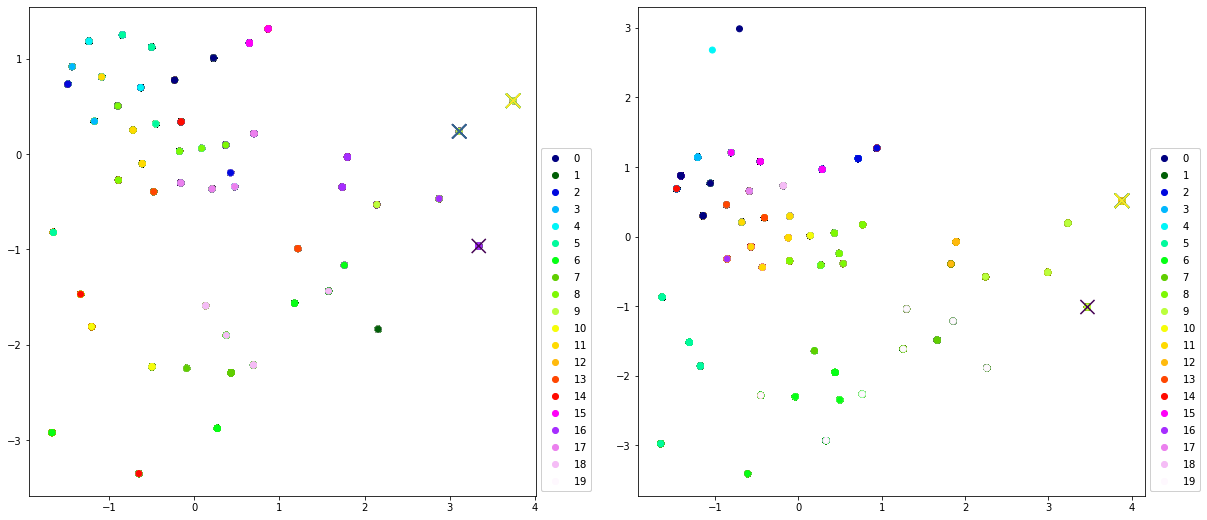

In [133]:
labels = kmeans.predict(data_to_cluster_jul20_std)
distances = kmeans.transform(data_to_cluster_jul20_std)
distances = numpy.min(distances, axis=1)

sorted_distances = numpy.argsort(distances)

fig = plt.figure(figsize=[20, 9])
ax = fig.add_subplot(1, 2, 1)
scatter = ax.scatter(data_to_cluster_jul20_std[:,1], data_to_cluster_jul20_std[:,2], c=labels, cmap=cm.get_cmap('gist_ncar'));
legend1 = ax.legend(*scatter.legend_elements(num=k), loc="lower left", bbox_to_anchor=(1, 0))
ax.add_artist(legend1)

ax.scatter(data_to_cluster_jul20_std[sorted_distances[abnormal_count:],1], data_to_cluster_jul20_std[sorted_distances[abnormal_count:],2], marker='x', s=200, c=range(abnormal_samples))

ax = fig.add_subplot(1, 2, 2)
scatter = ax.scatter(data_to_cluster_jul20_std[:,3], data_to_cluster_jul20_std[:,4], c=labels, cmap=cm.get_cmap('gist_ncar'));
legend1 = ax.legend(*scatter.legend_elements(num=k), loc="lower left", bbox_to_anchor=(1, 0))
ax.add_artist(legend1)

ax.scatter(data_to_cluster_jul20_std[sorted_distances[abnormal_count:],3], data_to_cluster_jul20_std[sorted_distances[abnormal_count:],4], marker='x', s=200, c=range(abnormal_samples))

We can visualise all the clusters and where the abnormalities exist in the above plot, which is a little bit hard to see, though clearly our anomalies all exist on the outskirts of New York.

As such, below we visualise the five most unusual points.

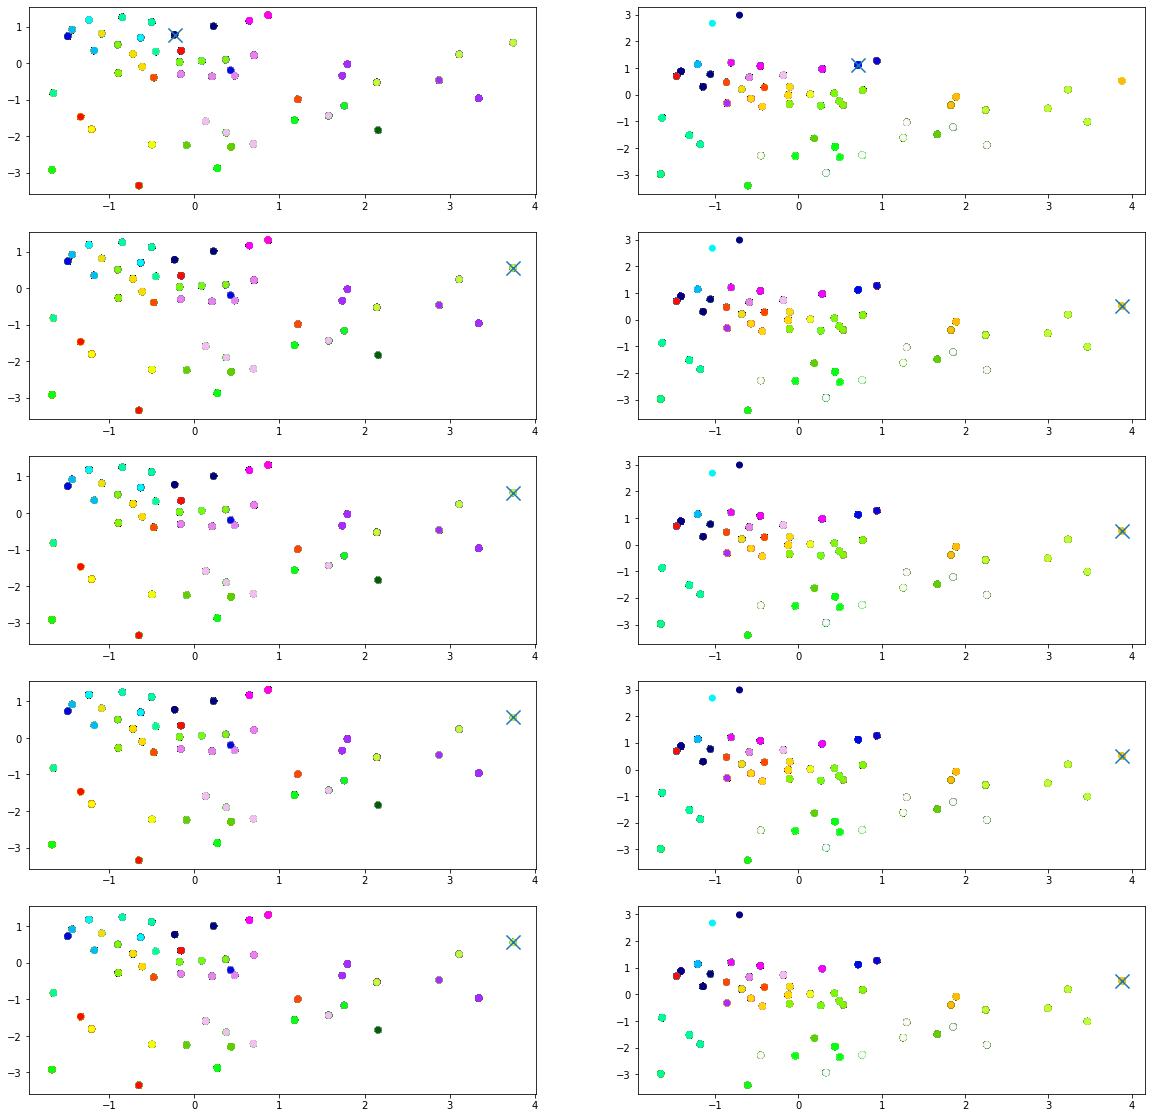

In [134]:
fig = plt.figure(figsize=[20, 20])
for i in range(5):
    ax = fig.add_subplot(5, 2, i*2 + 1)
    ax.scatter(data_to_cluster_jul20_std[:,1], data_to_cluster_jul20_std[:,2], c=labels, cmap=cm.get_cmap('gist_ncar'));
    ax.scatter(data_to_cluster_jul20_std[sorted_distances[-i],1], data_to_cluster_jul20_std[sorted_distances[-i],2], marker='x', s=200)

    ax = fig.add_subplot(5, 2, (i+1)*2)
    ax.scatter(data_to_cluster_jul20_std[:,3], data_to_cluster_jul20_std[:,4], c=labels, cmap=cm.get_cmap('gist_ncar'));
    ax.scatter(data_to_cluster_jul20_std[sorted_distances[-i],3], data_to_cluster_jul20_std[sorted_distances[-i],4], marker='x', s=200)

Considering the above, and the abnormal point details below (consider the last 5, these are the "most" abnormal), we see that the most abnormal points are all trips that are very long. 

We see that these points mostly belong to cluster 13, which itself is a cluster that tends to capture the long trips. Some points are long trips that go a long way, others are long trips that go not very far at all. 

Our other abnormal points belong to Cluster 9. These abnomal trips are all very long relative to the cluster mean, so this again is our likely reason for the points being abnormal.

Often with K-means we will find our abnormal points seem to exist at cluster boundaries, rather than explicitly being outliers. In our case we don't see this so much, and predominatley pull out outliers, though whether these are truly outliers or just points from a cluster of long trips is probably open for debate. This is really a result of how we are finding abnormal points. We don't have a measure of likelihood, what we have is distance to the assigned cluster centre. If a point lies in the middle of two clusters, or at the edge of a cluster, it will be a long way from a cluster centre whilst not necessarily being that unusual, and so may come back as being "unusual" with this measure.

In [135]:
scaled_centres = kmeans.cluster_centers_*data_to_cluster_sigma + data_to_cluster_mu
for i in range(k):
    print('Cluster Centre %d: %1.2f, %1.3f, %1.3f, %1.3f, %1.3f' % (i, scaled_centres[i, 0], scaled_centres[i, 1], scaled_centres[i, 2], scaled_centres[i, 3], scaled_centres[i, 4]))

print('')

scaled_samples = data_to_cluster_jul20_std[sorted_distances[abnormal_count:], :]*data_to_cluster_sigma + data_to_cluster_mu
abnormal_labels = labels[sorted_distances[abnormal_count:]]
for i in range(abnormal_samples):
    print('Abnormal Sample %d (Cluster %d): %1.2f, %1.3f, %1.3f, %1.3f, %1.3f' \
          % (i, abnormal_labels[i], scaled_samples[i, 0], scaled_samples[i, 1], scaled_samples[i, 2], \
             scaled_samples[i, 3], scaled_samples[i, 4]))

Cluster Centre 0: 502.43, 40.722, -74.044, 40.716, -74.036
Cluster Centre 1: 447.15, 40.736, -74.058, 40.737, -74.058
Cluster Centre 2: 415.10, 40.720, -74.039, 40.727, -74.034
Cluster Centre 3: 292.96, 40.716, -74.036, 40.716, -74.037
Cluster Centre 4: 1724.27, 40.721, -74.039, 40.722, -74.039
Cluster Centre 5: 752.35, 40.718, -74.043, 40.712, -74.060
Cluster Centre 6: 521.70, 40.730, -74.065, 40.723, -74.072
Cluster Centre 7: 428.56, 40.723, -74.071, 40.731, -74.064
Cluster Centre 8: 331.41, 40.720, -74.043, 40.726, -74.047
Cluster Centre 9: 733.63, 40.745, -74.046, 40.743, -74.047
Cluster Centre 10: 658.82, 40.712, -74.061, 40.718, -74.042
Cluster Centre 11: 288.16, 40.718, -74.043, 40.719, -74.044
Cluster Centre 12: 1341.79, 40.723, -74.043, 40.743, -74.047
Cluster Centre 13: 5179.16, 40.720, -74.046, 40.720, -74.046
Cluster Centre 14: 2708.09, 40.718, -74.049, 40.717, -74.050
Cluster Centre 15: 435.85, 40.727, -74.033, 40.722, -74.039
Cluster Centre 16: 880.68, 40.741, -74.049, 40

### GMM

We'll move onto the GMM now. As per K-means, we're using the same GMM we trained earlier.

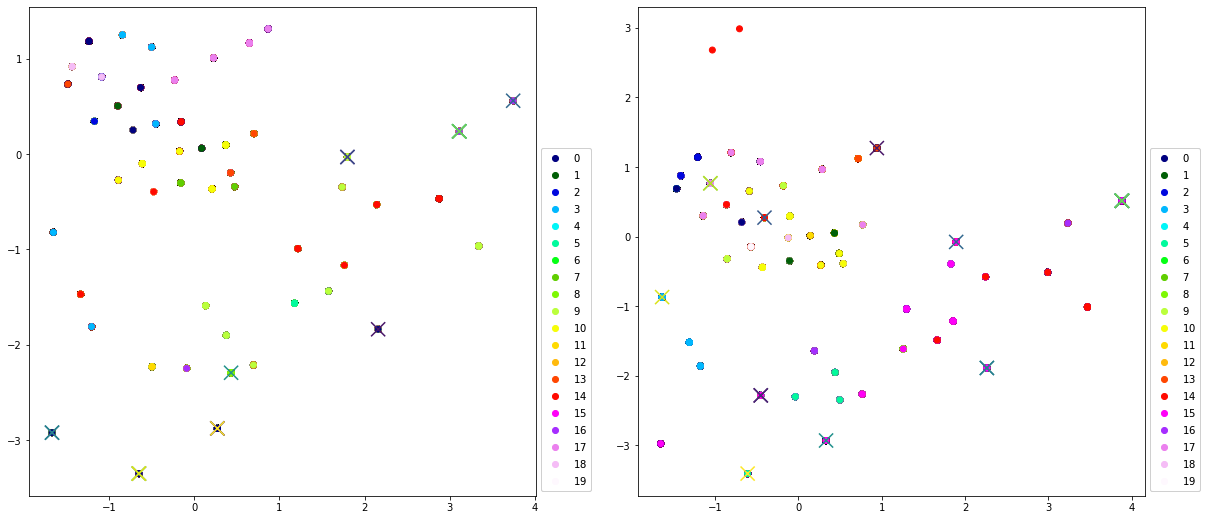

In [136]:
labels = gmm.predict(data_to_cluster_jul20_std)
scores = gmm.score_samples(data_to_cluster_jul20_std)
sorted_scores = numpy.flip(numpy.argsort(scores))

fig = plt.figure(figsize=[20, 9])
ax = fig.add_subplot(1, 2, 1)
scatter = ax.scatter(data_to_cluster_jul20_std[:,1], data_to_cluster_jul20_std[:,2], c=labels, cmap=cm.get_cmap('gist_ncar'));
legend1 = ax.legend(*scatter.legend_elements(num=k), loc="lower left", bbox_to_anchor=(1, 0))
ax.add_artist(legend1)
ax.scatter(data_to_cluster_jul20_std[sorted_scores[abnormal_count:],1], data_to_cluster_jul20_std[sorted_scores[abnormal_count:],2], marker='x', s=200, c=range(abnormal_samples))

ax = fig.add_subplot(1, 2, 2)
scatter = ax.scatter(data_to_cluster_jul20_std[:,3], data_to_cluster_jul20_std[:,4], c=labels, cmap=cm.get_cmap('gist_ncar'));
legend1 = ax.legend(*scatter.legend_elements(num=k), loc="lower left", bbox_to_anchor=(1, 0))
ax.add_artist(legend1)
ax.scatter(data_to_cluster_jul20_std[sorted_scores[abnormal_count:],3], data_to_cluster_jul20_std[sorted_scores[abnormal_count:],4], marker='x', s=200, c=range(abnormal_samples))

Similar to K-means, we'll look at the five most unusual points in isolation.

Again, we see that our most abnormal points are dominated by the trip duration, but others are capturing more unusual paths with fairly normal durations, which suggests that we're doing a better job of capturing trips that go in an unusual direction.

Perhaps of concern, all of our unusual points belong to one cluster (14), which suggests that perhaps our clustering is sub-optimal, or at least this cluster should be more closely investigated.

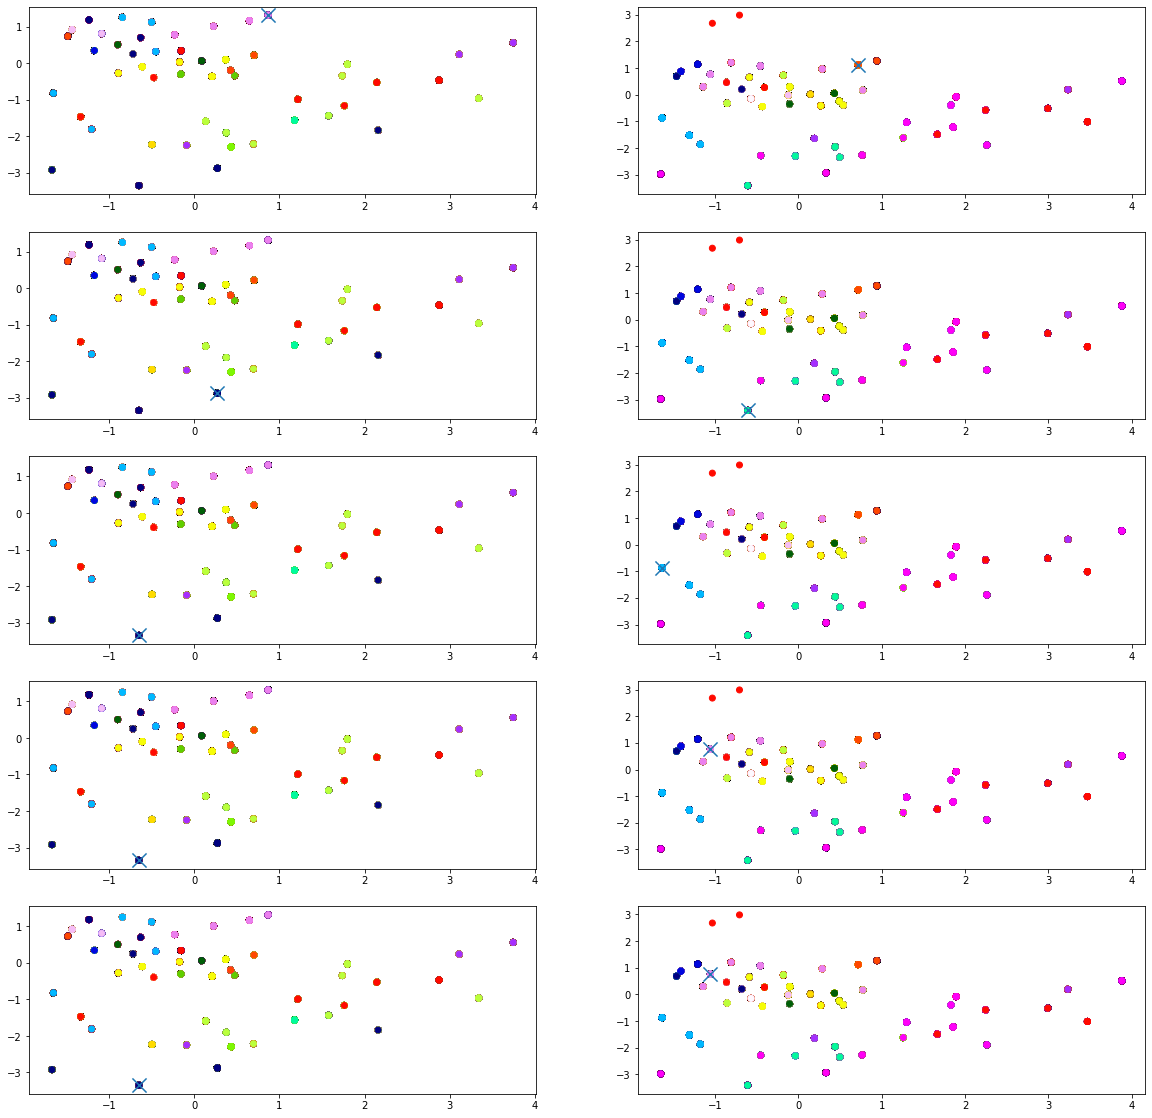

In [137]:
fig = plt.figure(figsize=[20, 20])
for i in range(5):
    ax = fig.add_subplot(5, 2, i*2 + 1)
    ax.scatter(data_to_cluster_jul20_std[:,1], data_to_cluster_jul20_std[:,2], c=labels, cmap=cm.get_cmap('gist_ncar'));
    ax.scatter(data_to_cluster_jul20_std[sorted_scores[-i],1], data_to_cluster_jul20_std[sorted_scores[-i],2], marker='x', s=200)

    ax = fig.add_subplot(5, 2, (i+1)*2)
    ax.scatter(data_to_cluster_jul20_std[:,3], data_to_cluster_jul20_std[:,4], c=labels, cmap=cm.get_cmap('gist_ncar'));
    ax.scatter(data_to_cluster_jul20_std[sorted_scores[-i],3], data_to_cluster_jul20_std[sorted_scores[-i],4], marker='x', s=200)

In [138]:
scaled_centres = gmm.means_*data_to_cluster_sigma + data_to_cluster_mu
for i in range(k):
    print('Cluster Centre %d: %1.2f, %1.3f, %1.3f, %1.3f, %1.3f' % (i, scaled_centres[i, 0], scaled_centres[i, 1], scaled_centres[i, 2], scaled_centres[i, 3], scaled_centres[i, 4]))

print('')

scaled_samples = data_to_cluster_jul20_std[sorted_scores[abnormal_count:], :]*data_to_cluster_sigma + data_to_cluster_mu
abnormal_labels = labels[sorted_scores[abnormal_count:]]
for i in range(abnormal_samples):
    print('Abnormal Sample %d (Cluster %d): %1.2f, %1.3f, %1.3f, %1.3f, %1.3f; likelihood: %f' \
          % (i, abnormal_labels[i], scaled_samples[i, 0], scaled_samples[i, 1], scaled_samples[i, 2], \
             scaled_samples[i, 3], scaled_samples[i, 4], scores[sorted_scores[abnormal_count + i]]))

Cluster Centre 0: 1755.21, 40.721, -74.046, 40.721, -74.046
Cluster Centre 1: 237.87, 40.720, -74.044, 40.725, -74.047
Cluster Centre 2: 394.58, 40.720, -74.044, 40.716, -74.035
Cluster Centre 3: 678.35, 40.718, -74.044, 40.712, -74.059
Cluster Centre 4: 212.13, 40.715, -74.035, 40.716, -74.035
Cluster Centre 5: 385.06, 40.730, -74.064, 40.723, -74.072
Cluster Centre 6: 438.64, 40.733, -74.062, 40.740, -74.055
Cluster Centre 7: 247.32, 40.725, -74.048, 40.720, -74.043
Cluster Centre 8: 402.34, 40.725, -74.069, 40.731, -74.064
Cluster Centre 9: 868.97, 40.734, -74.058, 40.722, -74.041
Cluster Centre 10: 721.31, 40.721, -74.043, 40.721, -74.043
Cluster Centre 11: 598.04, 40.715, -74.061, 40.718, -74.042
Cluster Centre 12: 167.03, 40.728, -74.034, 40.728, -74.035
Cluster Centre 13: 385.19, 40.720, -74.040, 40.726, -74.035
Cluster Centre 14: 2110.77, 40.724, -74.051, 40.724, -74.050
Cluster Centre 15: 1001.89, 40.721, -74.041, 40.733, -74.060
Cluster Centre 16: 398.51, 40.736, -74.057, 40.

Perhaps the nicest thing we get with the GMM is we get the likelihood (negative log likelihood), where a smaller value indicates more abnormal.

One odd thing we see is that all the abnormal points belong to cluster 19. Further inspection shows that they are all farily confidently assigned to cluster 19 as well.

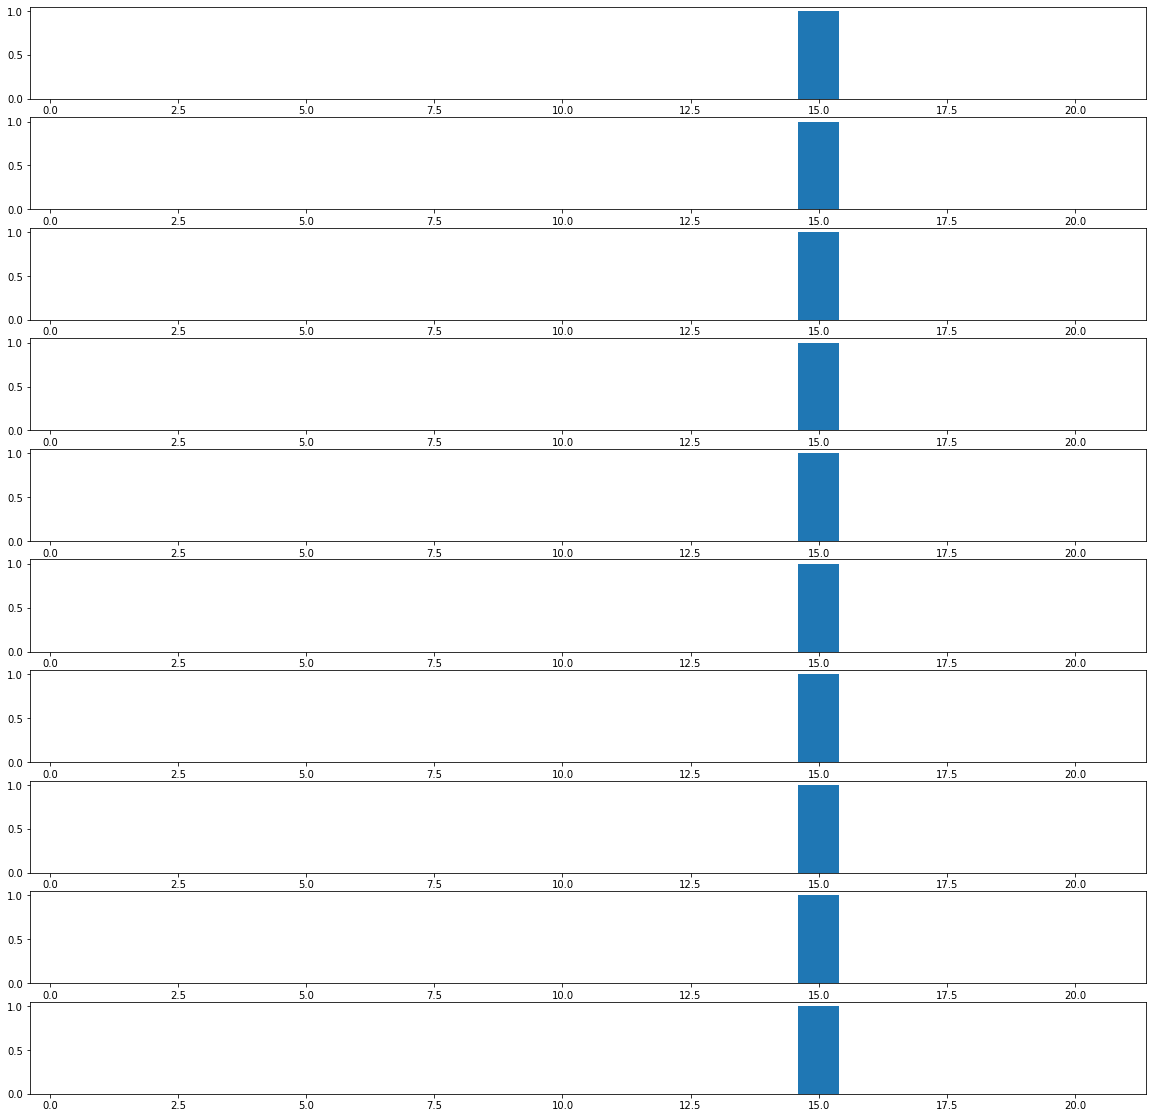

In [139]:
posterior = gmm.predict_proba(data_to_cluster_jul20_std[sorted_scores[-11:-1], :])
fig = plt.figure(figsize=[20, 20])
for i in range(10):
    ax = fig.add_subplot(10, 1, i+1)
    ax.bar(range(1,21), posterior[i,:])

This is not necessarily wrong, but would metrit further investigation. It may just be a quirk of the random seed, or it may be down to us not having enough clusters to properly describe the data, and thus having cluster 14 as a large cluster that trying to capture too many things, and ultimatley not capturing any one thing properly.

### Further Investigation

Let's do some further investigation now.

All of our unusual trips are long, and cluster centre 14 does seem to be the long trip cluster. We see that all of our trips are very long, though are also geographically somewhat diverse. This suggests that cluster 14 may be a fairly generic and broad cluster that just capturing a lot of stuff that doesn't fit elsewhere; really this could be a noise cluster.

Let's do a very coarse exploration of our data to try and understand where our problems may or may not lie. We have 5D data, which is difficult to plot, so we'll throw TSNE into the mix. We'll look at both all the clusters, and cluster 14 in isolation to try and understand it's size and distribution across the feature space. Note that by going to TSNE here, we're losing sense of the real meaning of the data, we can't really relate what we see back to duration or geography; instead what we're looking at is how cluster 14 is distributed relative to everything else.

/home/denman/vevns/cab420/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/denman/vevns/cab420/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'Cluster 14')

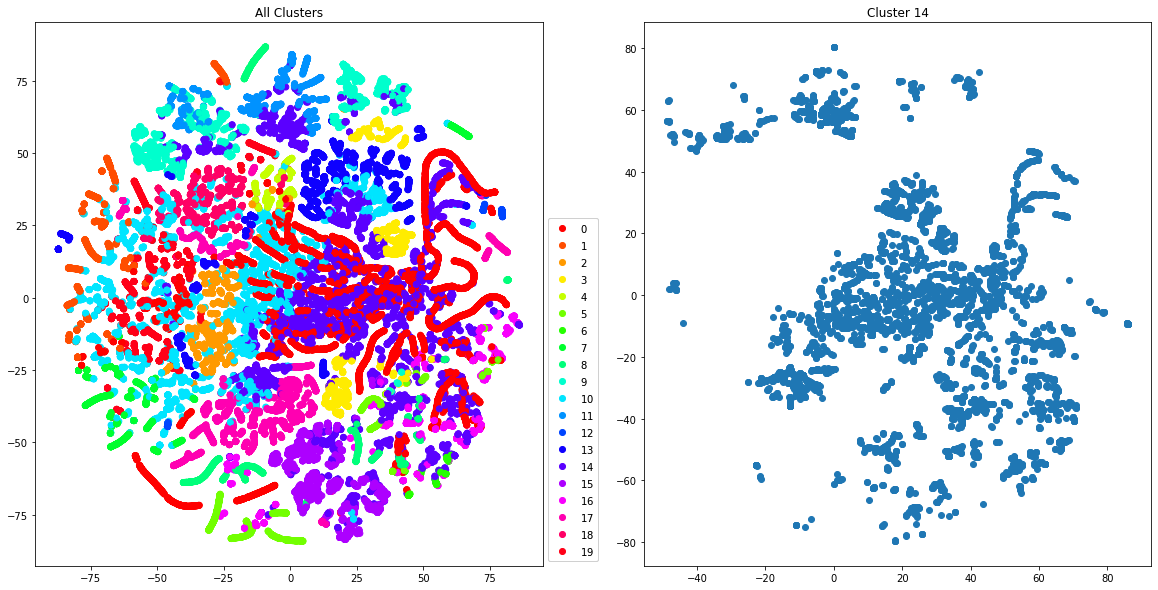

In [140]:
from sklearn.manifold import TSNE
embeddings = TSNE(random_state=4).fit_transform(data_to_cluster_jul20_std)

fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(1, 2, 1)
scatter = ax.scatter(embeddings[:,0], embeddings[:,1], c=labels, cmap=cm.get_cmap('hsv'))
legend1 = ax.legend(*scatter.legend_elements(num=k), loc="lower left", bbox_to_anchor=(1, 0))
ax.add_artist(legend1)
ax.set_title('All Clusters')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(embeddings[labels==14,0], embeddings[labels==14,1], cmap=cm.get_cmap('hsv'))
ax.set_title('Cluster 14')

From the above, it's quite clear that cluster 14 is covering a lot of ground. There is huge spread here, which is backed up by looking at the covariances of a couple of clusters.

In [141]:
print(gmm.covariances_[1])
print(gmm.covariances_[14])

[[ 0.01439028 -0.01111366  0.00599426  0.01219565 -0.00222795]
 [-0.01111366  0.04303105 -0.01786489  0.0162702   0.00543474]
 [ 0.00599426 -0.01786489  0.01442323 -0.0071833  -0.00113384]
 [ 0.01219565  0.0162702  -0.0071833   0.0908442   0.03956906]
 [-0.00222795  0.00543474 -0.00113384  0.03956906  0.05854557]]
[[ 3.82599276 -0.5448736   0.75716123 -0.70859102  0.51747788]
 [-0.5448736   1.76911087  0.02964748  0.47289722 -0.46105208]
 [ 0.75716123  0.02964748  1.46178635 -0.30557708  0.64489288]
 [-0.70859102  0.47289722 -0.30557708  1.98232069  0.11259561]
 [ 0.51747788 -0.46105208  0.64489288  0.11259561  1.50229375]]


So, where too from here?

At this point, it would be fair to conclude that with 20 clusters we are possibly underclustering, i.e. we're grouping some samples together that we probably should not be. The solution to this is simply to increase the number of clusters, so let's do that. For the sake of keeping it remotely possible to visualise things, we'll go to 40 clusters.

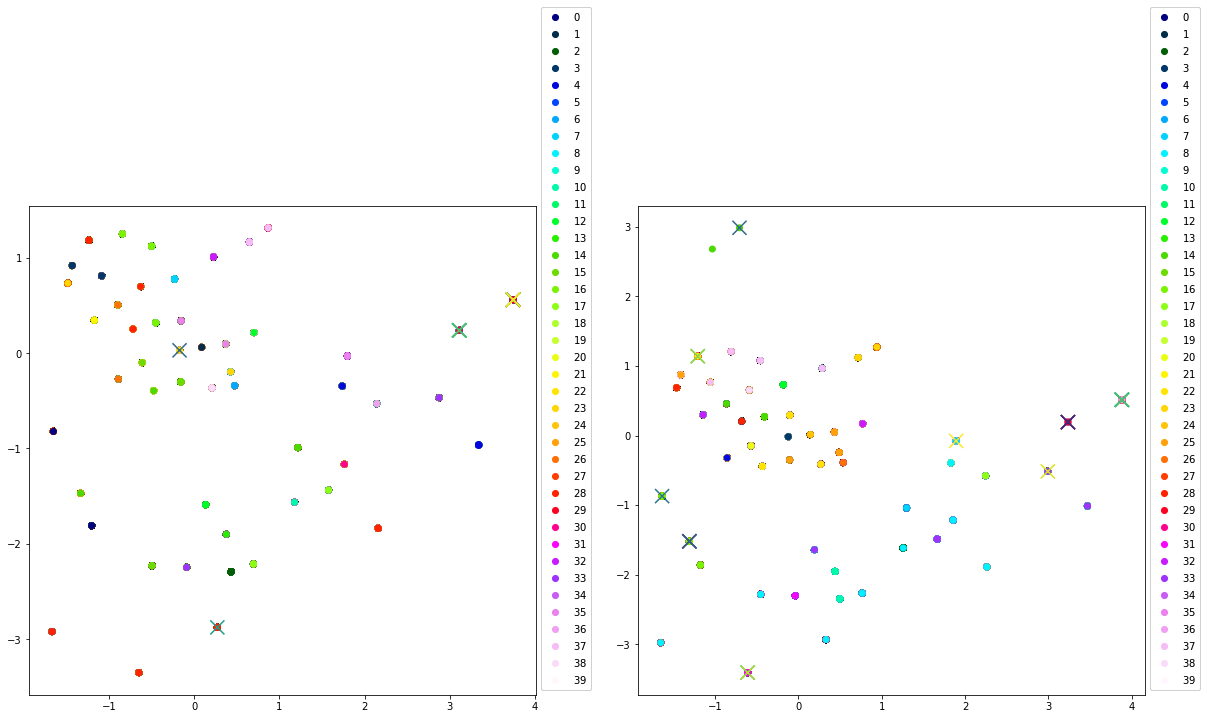

In [142]:
k = 40
gmm = GaussianMixture(k, random_state=4)
gmm.fit(data_to_cluster_std)
labels = gmm.predict(data_to_cluster_jul20_std)
scores = gmm.score_samples(data_to_cluster_jul20_std)
sorted_scores = numpy.flip(numpy.argsort(scores))

fig = plt.figure(figsize=[20, 9])
ax = fig.add_subplot(1, 2, 1)
scatter = ax.scatter(data_to_cluster_jul20_std[:,1], data_to_cluster_jul20_std[:,2], c=labels, cmap=cm.get_cmap('gist_ncar'));
legend1 = ax.legend(*scatter.legend_elements(num=k), loc="lower left", bbox_to_anchor=(1, 0))
ax.add_artist(legend1)
ax.scatter(data_to_cluster_jul20_std[sorted_scores[abnormal_count:],1], data_to_cluster_jul20_std[sorted_scores[abnormal_count:],2], marker='x', s=200, c=range(abnormal_samples))

ax = fig.add_subplot(1, 2, 2)
scatter = ax.scatter(data_to_cluster_jul20_std[:,3], data_to_cluster_jul20_std[:,4], c=labels, cmap=cm.get_cmap('gist_ncar'));
legend1 = ax.legend(*scatter.legend_elements(num=k), loc="lower left", bbox_to_anchor=(1, 0))
ax.add_artist(legend1)
ax.scatter(data_to_cluster_jul20_std[sorted_scores[abnormal_count:],3], data_to_cluster_jul20_std[sorted_scores[abnormal_count:],4], marker='x', s=200, c=range(abnormal_samples))

In [143]:
scaled_centres = gmm.means_*data_to_cluster_sigma + data_to_cluster_mu
for i in range(k):
    print('Cluster Centre %d: %1.2f, %1.3f, %1.3f, %1.3f, %1.3f' % (i, scaled_centres[i, 0], scaled_centres[i, 1], scaled_centres[i, 2], scaled_centres[i, 3], scaled_centres[i, 4]))

print('')

scaled_samples = data_to_cluster_jul20_std[sorted_scores[abnormal_count:], :]*data_to_cluster_sigma + data_to_cluster_mu
abnormal_labels = labels[sorted_scores[abnormal_count:]]
for i in range(abnormal_samples):
    print('Abnormal Sample %d (Cluster %d): %1.2f, %1.3f, %1.3f, %1.3f, %1.3f; likelihood: %f' \
          % (i, abnormal_labels[i], scaled_samples[i, 0], scaled_samples[i, 1], scaled_samples[i, 2], \
             scaled_samples[i, 3], scaled_samples[i, 4], scores[sorted_scores[abnormal_count + i]]))

Cluster Centre 0: 1035.22, 40.713, -74.061, 40.719, -74.051
Cluster Centre 1: 198.59, 40.722, -74.045, 40.726, -74.047
Cluster Centre 2: 378.90, 40.724, -74.071, 40.731, -74.064
Cluster Centre 3: 308.33, 40.714, -74.039, 40.719, -74.043
Cluster Centre 4: 712.57, 40.740, -74.050, 40.722, -74.046
Cluster Centre 5: 1619.72, 40.729, -74.042, 40.726, -74.034
Cluster Centre 6: 207.33, 40.726, -74.047, 40.722, -74.045
Cluster Centre 7: 513.00, 40.721, -74.037, 40.721, -74.044
Cluster Centre 8: 983.72, 40.721, -74.042, 40.730, -74.063
Cluster Centre 9: 411.64, 40.741, -74.053, 40.733, -74.063
Cluster Centre 10: 314.59, 40.731, -74.064, 40.725, -74.069
Cluster Centre 11: 538.34, 40.734, -74.061, 40.744, -74.054
Cluster Centre 12: 376.66, 40.721, -74.043, 40.723, -74.037
Cluster Centre 13: 733.34, 40.725, -74.069, 40.718, -74.041
Cluster Centre 14: 3475.94, 40.721, -74.049, 40.721, -74.053
Cluster Centre 15: 304.59, 40.722, -74.047, 40.720, -74.043
Cluster Centre 16: 728.18, 40.719, -74.041, 40.

By complete coincidence, we've got cluster 14 again as being our 'long trip cluster' and most of our anomalies are coming from there. Again looking at TSNE and our covariances, we see that this is a very widely spread cluster.

/home/denman/vevns/cab420/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/denman/vevns/cab420/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[[ 0.00868824 -0.00439844  0.00626354  0.00407162 -0.00077693]
 [-0.00439844  0.01577304 -0.00583707  0.00310762  0.00069889]
 [ 0.00626354 -0.00583707  0.02063649 -0.00023962  0.00555609]
 [ 0.00407162  0.00310762 -0.00023962  0.03610479  0.03305058]
 [-0.00077693  0.00069889  0.00555609  0.03305058  0.06087851]]
[[ 5.59370973 -0.38147238  0.73175693 -0.28065605  1.33569167]
 [-0.38147238  0.89805791 -0.11518065  0.29309119 -0.15015374]
 [ 0.73175693 -0.11518065  1.47271968 -0.10786489  0.73614194]
 [-0.28065605  0.29309119 -0.10786489  1.95639015  0.13351121]
 [ 1.33569167 -0.15015374  0.73614194  0.13351121  1.48194095]]


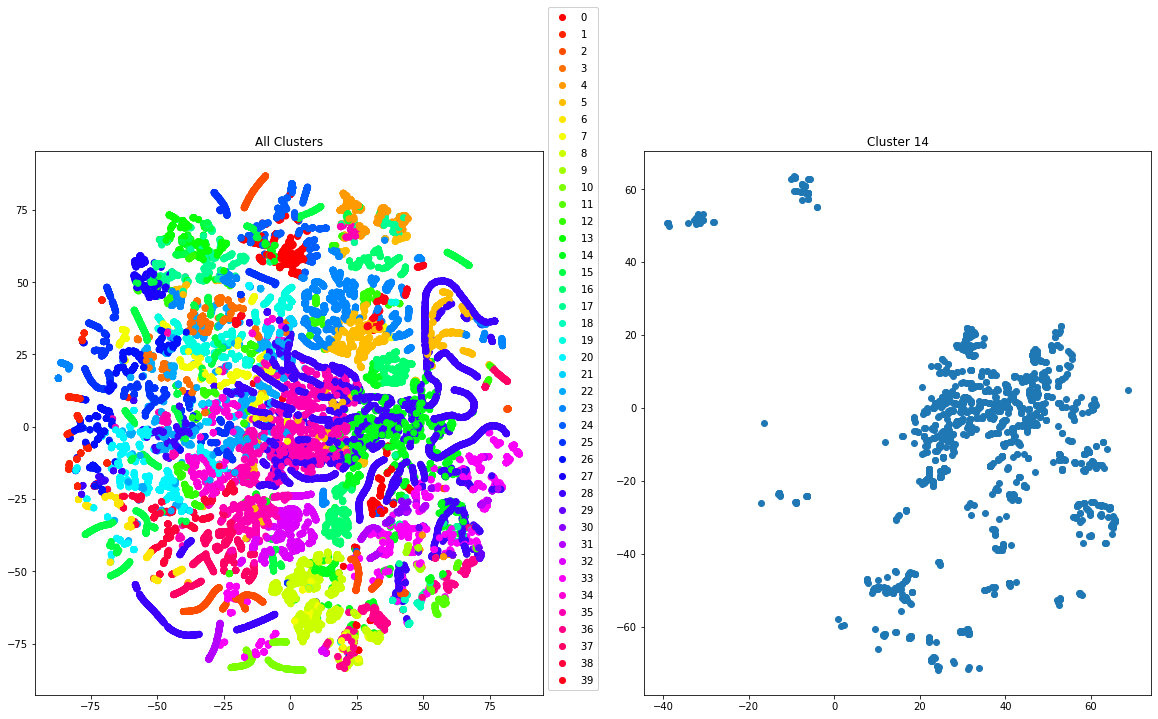

In [144]:
from sklearn.manifold import TSNE
embeddings = TSNE(random_state=4).fit_transform(data_to_cluster_jul20_std)

fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(1, 2, 1)
scatter = ax.scatter(embeddings[:,0], embeddings[:,1], c=labels, cmap=cm.get_cmap('hsv'))
legend1 = ax.legend(*scatter.legend_elements(num=k), loc="lower left", bbox_to_anchor=(1, 0))
ax.add_artist(legend1)
ax.set_title('All Clusters')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(embeddings[labels==14,0], embeddings[labels==14,1], cmap=cm.get_cmap('hsv'))
ax.set_title('Cluster 14')

print(gmm.covariances_[1])
print(gmm.covariances_[14])

So where does this leave us?

There are a few things to consider:
* Many of these points probably are abnormal. We saw from the brief data exploration at the top, we have a lot of outliers in the trip duration, but these are all outliers, and a lot of our abnormal samples are from the high end of our allowed time range
* We may still be under-clustering. We have a lot of data, and there are a lot of possible trip types, is 40 really enough?
* Cluster 14 is a widely distributed cluster, which seems to capture a lot of variation. It's not unreasonable to consider that this is a noise cluster that exists to capture points that don't fit anywhere else all that well.

We can also look at our cluster weights to get a sense of where cluster 14 sits in the scheme of things, and what's happening in the 2020 data.

Text(0.5, 1.0, 'July 2020')

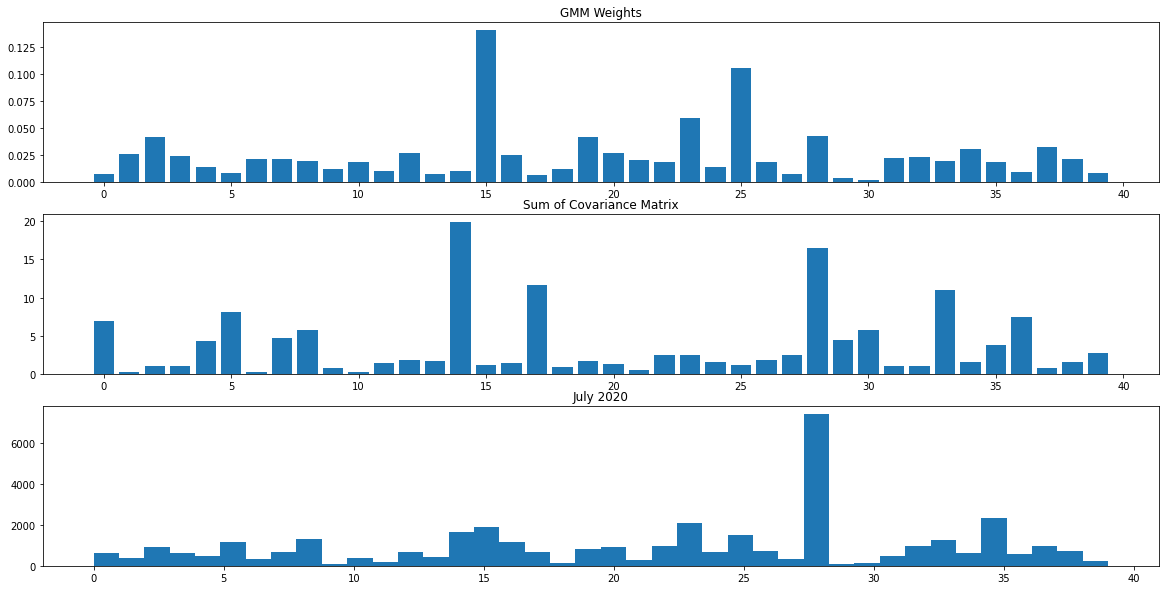

In [145]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(3, 1, 1)
ax.bar(x=[i for i in range(40)],height=gmm.weights_)
ax.set_title('GMM Weights')

ax = fig.add_subplot(3, 1, 2)
ax.bar(x=[i for i in range(40)],height=numpy.sum(numpy.abs(gmm.covariances_), axis=(1,2)))
ax.set_title('Sum of Covariance Matrix')

ax = fig.add_subplot(3, 1, 3)
ax.hist(labels, bins=40)
ax.set_title('July 2020')   

Cluster weights show cluster 14 is pretty uncommon in the grand scheme of things, with less than 1% of the weight in that cluster. This is far from our rarest cluster, but it is the most widely spread if we consider the sum of the covariance matrix as a measure of total spread (which we will - though mathematically I'm not convinced that this is totally valid). We also see that this cluster is far more common in the 2020 data. 

So we have a couple of aspects at play:
* This cluster does look somewhat like a catch all cluster for long trips in particular; this could be a noise cluster, or it could be capturing long trips in a particular area (though probably a fairly large area). 
* We have a change in behaviour between 2019 and the pandemic (not a surprise) which means that we're lumping a lot more stuff in cluster 14. It's entirely possible that a lot of this stuff doesn't really fit cluster 14 as it is itself a large catch-all type cluster (probably), but it doesn't fit anywhere else either.

Where to from here then? This example will not continue rambling on at this point, but it's fair to say that our abnormal samples being almost all from cluster 14 is odd, but perhaps somewhat understandable. There are a number of things that could be considered as next steps at this point:
* Add more clusters. Cluster 14, and a few others, are still very broad. This perhaps suggests that we could split a couple of these up a little more; or at the very least re-run with a new random seed and see if that helps.
* Look at more noise filtering on the 2019 data; or perhaps at least improved noise filtering as what we've done is a little crude.
* Look at adding another data into our model to better separate samples. For example, the customer type could help find trips that belong to hard core cyclists and separate those from others. Maybe this would help break things up.
* Explore the data further. Our understanding of cluster 14 is not great as yet - we could continue exploring the data and looking at other ways to visualise this to help better understand what we are observing.

## Final Thoughts

In this example we've considered two applications of clustering:
* Knowledge discovery
* Anomaly detection

We've use both K-Means and GMMs for this, and both have worked to a point. On the whole, the GMM offers us a bit more flexibility in this data due to:
* The ability to capture various size and shaped clusters, which allows us to better model the data
* The ability to pull out likelihood values gives us a more meaninful way to identify abnormal points

That said, our GMM is much more computationally demanding to train, which while ok on this dataset (though getting the BIC curve is very slow), could become a problem as dataset size increases further (for example, if we had a whole year of data). 

It's also worth noting that as we change the number of clusters, we'll get very different results. In particular, using more clusters. You are encouraged to re-run this with different numbers of clusters (I'd recommend commenting out the blocks that plot reconstruction error and BIC) and seeing what changes.